In [4]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.6 MB/s eta 0:00:00


In [8]:
# 1. 라이브러리 및 데이터 준비
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

# 데이터셋 다운로드 및 준비
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# 데이터 증강 및 전처리
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['sunflowers', 'daisy', 'dandelion', 'tulips', 'roses']
클래스 수: 5
전체 이미지 개수: 3670
sunflowers: 699개
daisy: 633개
dandelion: 898개
tulips: 799개
roses: 641개
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


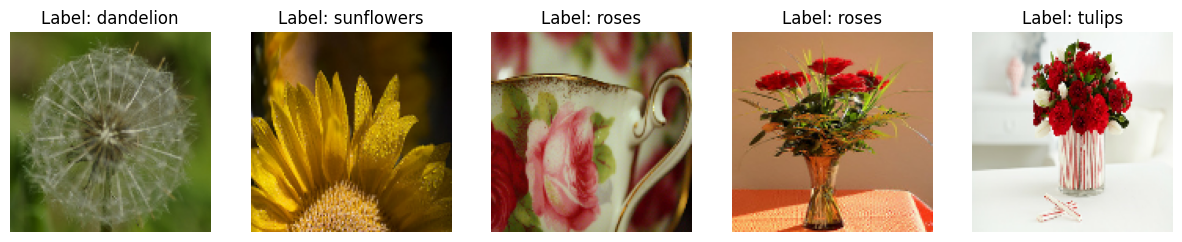

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):  # 첫 배치에서 5장만 출력
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

In [10]:
def build_resnet50():
    base = keras.applications.ResNet50(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_efficientnet():
    base = keras.applications.EfficientNetB0(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_densenet():
    base = keras.applications.DenseNet121(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenet():
    base = keras.applications.MobileNetV2(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vit():
    import keras_cv
    # Use VisionTransformer instead of VisionTransformerClassifier
    # and specify the classification head
    base_model = keras_cv.models.VisionTransformer.from_preset(
        "vit_base_imagenet21k",
        include_rescaling=False,  # Rescaling is already done
        include_top=False
    )
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_attention_cnn():
    # 간단한 Self-Attention Layer 추가 CNN
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)
    # MultiHeadAttention
    x = layers.Reshape((32*32, 64))(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_unet_classifier():
    # U-Net 기반 분류기 (Encoder만 사용)
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)
    x = layers.GlobalAveragePooling2D()(p3)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model_builders = {
    "ResNet50": build_resnet50,
    "EfficientNetB0": build_efficientnet,
    "DenseNet121": build_densenet,
    "MobileNetV2": build_mobilenet,
    "ViT": build_vit,
    "Attention-CNN": build_attention_cnn,
    "U-Net-Classifier": build_unet_classifier,
}

results = []
EPOCHS = 5  # 빠른 테스트를 위해 5, 실제는 10~20 추천

for name, builder in model_builders.items():
    print(f"Training {name} ...")
    model = builder()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=2
    )
    val_acc = max(history.history['val_accuracy'])
    results.append({"Model": name, "Best Val Accuracy": val_acc})

# 4. 결과 비교 표 출력
results_df = pd.DataFrame(results)
display(results_df)

# 5. 성능 시각화
results_df.plot(kind='bar', x='Model', y='Best Val Accuracy', legend=False)
plt.title("모델별 꽃 분류 성능 비교")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.show()

Training ResNet50 ...
Epoch 1/5
92/92 - 19s - 206ms/step - accuracy: 0.2793 - loss: 1.5947 - val_accuracy: 0.3569 - val_loss: 1.5039
Epoch 2/5
92/92 - 5s - 59ms/step - accuracy: 0.3331 - loss: 1.5150 - val_accuracy: 0.3665 - val_loss: 1.4880
Epoch 3/5
92/92 - 5s - 59ms/step - accuracy: 0.3525 - loss: 1.4888 - val_accuracy: 0.3733 - val_loss: 1.4838
Epoch 4/5
92/92 - 10s - 112ms/step - accuracy: 0.3675 - loss: 1.4701 - val_accuracy: 0.3624 - val_loss: 1.4873
Epoch 5/5
92/92 - 10s - 108ms/step - accuracy: 0.3787 - loss: 1.4606 - val_accuracy: 0.3678 - val_loss: 1.4425
Training EfficientNetB0 ...
Epoch 1/5
92/92 - 18s - 198ms/step - accuracy: 0.2268 - loss: 1.6349 - val_accuracy: 0.2139 - val_loss: 1.6090
Epoch 2/5
92/92 - 7s - 73ms/step - accuracy: 0.2289 - loss: 1.6058 - val_accuracy: 0.2398 - val_loss: 1.6037
Epoch 3/5
92/92 - 3s - 33ms/step - accuracy: 0.2309 - loss: 1.6045 - val_accuracy: 0.2398 - val_loss: 1.6078
Epoch 4/5
92/92 - 6s - 60ms/step - accuracy: 0.2377 - loss: 1.6013 - v

AttributeError: module 'keras_cv.api.models' has no attribute 'VisionTransformerClassifier'